## ch02-PySpark

<div style="text-align: right"> Initial upload: 2022.03.31 </div>
<div style="text-align: right"> Last update: 2022.03.31</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 50

from pylab import rcParams

rcParams['figure.figsize'] = 14, 8

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F

In [3]:
import os
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score

In [4]:
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'

spark = SparkSession.builder.master('local[*]').getOrCreate() # 세션생성 및 컨텍스트 정의 : 스파크 엔진과 연결지점을 만들어 스파크 기능 사용하기 위함
spark.sparkContext._conf.getAll()

[('spark.app.id', 'local-1648717466118'),
 ('spark.driver.port', '64681'),
 ('spark.driver.host', '127.0.0.1'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.startTime', '1648717464646'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.warehouse.dir',
  'file:/C:/Users/km.yu99/Desktop/Project/mlflow_study/mlflow를%20활용한%20mlops/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

In [5]:
print(pyspark.__version__)

3.2.1


Pyspark에 데이터프레임 생성기능이 있어 pandas를 사용하지 않아도 된다.

In [6]:
data_path = 'data/creditcard.csv'

In [7]:
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [8]:
labelColumn = 'Class'

In [9]:
columns = df.columns

In [10]:
numericCols = columns
numericCols.remove(labelColumn)

In [11]:
print(numericCols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


두줄 만 데이터 살펴보기

In [12]:
df.show(2)

+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
|Time|              V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V14|              V15|               V16|               V17|               V18|               V19|                V20|               V21|               V22|               V23|       

- 보기가 좋지 않다. 다행히 판다스로 변환해서 출력하는 기능이 있다.

In [13]:
df.toPandas().head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


pyspark의 데이터 처리 절차는 pandas와 다르다. 
모델을 학습하려면 feature라는 벡터를 전달해야함

In [14]:
stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
stages += [assembler]

In [15]:
stages

[VectorAssembler_f43acec7fc80]

In [16]:
dfFeatures = df.select(F.col(labelColumn).alias('label'), *numericCols)

In [17]:
dfFeatures

DataFrame[label: int, Time: double, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double]

이제 정상, 비정상 데이터를 분할 한다.

In [21]:
normal = dfFeatures.filter('Class==0').sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = dfFeatures.filter('Class==1')

In [30]:
normal_train, normal_test = normal.randomSplit([0.8, 0.2], seed=2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2], seed = 2020)

정상 비정상을 합친다.

In [31]:
train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

In [35]:
train.count()

114161

In [36]:
test.count()

28465

파이프라인을 구서하고 피처벡터를 생성한다.

In [37]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(dfFeatures)

train = pipelineModel.transform(train)
test = pipelineModel.transform(test)

selectedCols = ['label', 'features'] + numericCols

train = train.select(selectedCols)
test = test.select(selectedCols)

print('Training Dataset Count: ', train.count())
print('Test Dataset Count: ', test.count())

Training Dataset Count:  114161
Test Dataset Count:  28465


### 모델 학습

In [38]:
lr = LogisticRegressionPySpark(featuresCol='features', labelCol='label', maxIter=10)
lrModel = lr.fit(train)

In [39]:
lrModel

LogisticRegressionModel: uid=LogisticRegression_06234ab02ade, numClasses=2, numFeatures=30

In [40]:
trainingSummary = lrModel.summary

In [41]:
trainingSummary

In [42]:
pyspark_auc_score = trainingSummary.areaUnderROC

In [43]:
pyspark_auc_score

0.9833605861111903

### 모델 평가

In [50]:
predictions = lrModel.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [51]:
evaluations = lrModel.evaluate(test)

In [52]:
evaluations

In [53]:
accuracy = evaluations.accuracy

In [54]:
accuracy

0.9989460741261198

In [55]:
print(roc_auc_score(y_pred, y_true))
print(pyspark_auc_score)
print(accuracy)

0.9469809470310036
0.9833605861111903
0.9989460741261198


ROC 커브 그리기

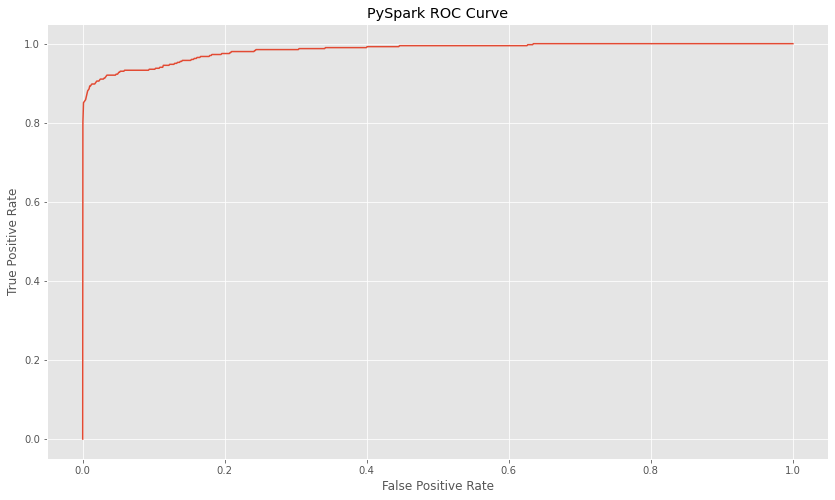

In [56]:
pyspark_roc = trainingSummary.roc.toPandas()

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'], pyspark_roc['TPR'])

conf matrix

Text(0.5, 51.0, 'Predicted')

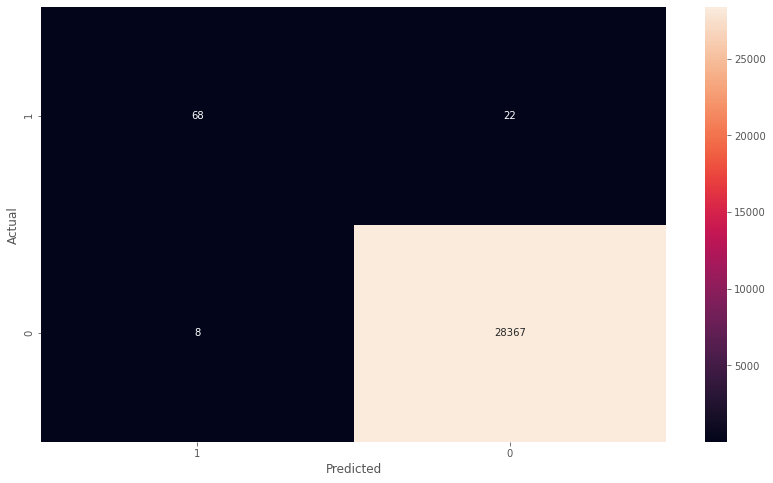

In [57]:
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()

plt.ylabel('Actual')
plt.xlabel('Predicted')

- scikit learn으로 학습했을 때보다 Recall 이 좋다.
- why???